In [1]:
# Importing all the libraries we need
import pandas as pd
import numpy as np
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import math

In [2]:
# Some initalizations to help our ETL phase
player_data = pd.DataFrame()
hand = pd.DataFrame()
hand_history = pd.DataFrame()
hero_hands = pd.DataFrame()

index = 0
num_players = 0
position_counter = 0
active_infront = 0
actions = [' allin ', ' bets ', ' calls ', ' checks', ' folds', ' raises ']
stage = ['blinds','preflop', 'flop', 'turn', 'river']
stage_counter = 1
pot_size = 0
card_counter = True
flop1 = ""
flop2 = ""
flop3 = ""
turn = ""
river = ""
suits = ["c", "d", "s", "h"]
cards = [(str(rank)+suit) for rank in range(2,15) for suit in suits]
raw = pd.DataFrame()

In [3]:
# Computationally intensive ETL code. The repository contains the output entitled "HANDS.csv"
files = ['File196', 'File198','File199','File200','File201','File203','File204','Export Holdem Manager 2.0 12292016131233','Export Holdem Manager 2.0 12302016144830']
for file in files:
	raw = raw.append(pd.read_csv('C:/poker/Just files/'+ file + '.txt', header=None, error_bad_lines=False, warn_bad_lines=False), ignore_index=True)

for line in raw.iloc[:,0]:
    if 'Game started at' in line:
        start_time = line.split('at: ')[1]
        start_time = datetime.strptime(start_time, '%Y/%m/%d %H:%M:%S')
    elif 'Game ID:' in line:
        game_id = int(line.split()[2])	
        blinds = float(line.split()[3].split("/")[1])

    elif re.search(r'Seat [0-9]+:', line):
        num_players += 1
        split = line.split()
        # Creating the Second Dataframe using dictionary 

        current_player = pd.DataFrame({
        	"Player Name":str(split[2]), 
            "Starting Stack":float(split[-1][1:-2]),  
            # is Nan faster?!?
            "Position":100,
            "Start Time":start_time,
            "Game ID":game_id,
            "Big Blind":blinds
            },index=[0]) 
            # for appending df2 at the end of df1 
        player_data = player_data.append(current_player, ignore_index = True)

    elif re.search(r'has [a-z]+ blind', line):
    	hand.loc[index, 'Player Name'] = line.split()[1]
    	hand.loc[index, 'Action'] = line.split()[-3] + ' blind'
    	hand.loc[index, 'Amount'] = float(line.split()[-1][1:-1])
    	hand.loc[index, 'Stage'] = stage[stage_counter]
    	hand.loc[index, 'Pot Size'] = pot_size
    	pot_size += hand.loc[index, 'Amount']
    	hand.loc[index, 'Invested Post Action'] = hand.loc[index, 'Amount']
    	hand.loc[index, 'Starting Stack'] = player_data[player_data['Player Name'] == line.split()[1]]['Starting Stack'].sum()
    	hand.loc[index, 'Invested Pre Action'] = 0
    	hand.loc[index, 'Remaining Pre Action'] = hand.loc[index, 'Starting Stack']
    	if player_data[player_data['Player Name'] == line.split()[1]].iloc[0,:].loc['Position']==100:
    		player_data.loc[player_data['Player Name'] == line.split()[1], 'Position'] = position_counter
    		position_counter += 1
    	index += 1

    elif 'Player IlxxxlI received' in line:

        if(card_counter):
        	first_card = {"Game ID": game_id,'Card 1': line.split()[-1][1:-1]}
        	hero_hands = hero_hands.append(first_card, ignore_index=True)
        else:
        	hero_hands.loc[hero_hands["Game ID"]==game_id, 'Card 2'] = line.split()[-1][1:-1]
        card_counter = not card_counter
            
    # this is sloppy
    elif any(ele in line for ele in actions):
        for ele in actions:
            if ele in line:
                hand.loc[index, 'Player Name'] = line.split()[1]
                hand.loc[index, 'Action'] = ele
                hand.loc[index, 'Flop 1'] = flop1
                hand.loc[index, 'Flop 2'] = flop2
                hand.loc[index, 'Flop 3'] = flop3
                hand.loc[index, 'Turn'] = turn
                hand.loc[index, 'River'] = river
                hand.loc[index, 'Active'] = active_infront

                # For simplicity, we can merge the allin and bet action to raise
                if ele == ' allin ' or ele == ' bets ':
                	hand.loc[index, 'Action'] = ' raises '

                hand.loc[index, 'Stage'] = stage[stage_counter]

                prior_action = hand[hand['Player Name']==line.split()[1]]['Invested Post Action'].max()

                if math.isnan(prior_action):
                	prior_action = 0
                hand.loc[index, 'Invested Pre Action'] = prior_action
                
                hand.loc[index, 'Starting Stack'] = player_data[player_data['Player Name'] == line.split()[1]]['Starting Stack'].sum()
                hand.loc[index, 'Remaining Pre Action'] = hand.loc[index, 'Starting Stack'] - hand.loc[index, 'Invested Pre Action']
                hand.loc[index, 'Pot Size'] = pot_size
                hand.loc[index, 'Amount to Call'] = hand['Invested Post Action'].max() - prior_action

                if ele == ' raises ' or ele == ' bets ' or ele ==' allin ' or ele== ' calls ':
                	hand.loc[index, 'Amount'] = float(line.split()[-1][1:-1])             	
                	prior_stage = hand[hand['Stage']==stage[stage_counter-1]]['Invested Post Action'].max()
                	active_infront += 1

                	if math.isnan(prior_stage):
                		prior_stage = 0

                	hand.loc[index, 'Invested Post Action'] = hand.loc[index, 'Amount'] + prior_stage
                	pot_size += hand.loc[index, 'Invested Post Action'] - hand.loc[index, 'Invested Pre Action']

                elif ele == ' folds' or ele == ' checks':
                	hand.loc[index, 'Invested Post Action'] = hand.loc[index, 'Invested Pre Action']

                if player_data[player_data['Player Name'] == line.split()[1]].iloc[0,:].loc['Position']==100:
                	player_data.loc[player_data['Player Name'] == line.split()[1], 'Position'] = position_counter
                	position_counter += 1
               	index += 1
                break

    elif '*** FLOP ***' in line:
    	flop1 = line.split()[-1][:-1]
    	flop2 = line.split()[-2]
    	flop3 = line.split()[-3][1:]
    	stage_counter += 1

    elif '*** TURN ***' in line:
    	turn = line.split()[-1][1:-1]
    	stage_counter += 1

    elif '*** RIVER ***' in line:
    	river = line.split()[-1][1:-1]
    	stage_counter += 1

    elif 'Game ended at:' in line:
        hand['Number of Players'] = num_players
        hand = hand.drop('Starting Stack', axis=1)
        hand = pd.merge(hand, player_data, on = 'Player Name', how = 'left')
        player_data = player_data.iloc[0:0]
        hand_history = hand_history.append(hand, ignore_index = True)

        hand = pd.DataFrame()
        position_counter = 0
        stage_counter = 1
        pot_size = 0
        num_players = 0
        active_infront = 0
        flop1 = ""
        flop2 = ""
        flop3 = ""
        turn = ""
        river = ""

hero_view = hand_history[hand_history['Player Name'] == 'IlxxxlI']
hero_view = hero_view[hero_view['Action'] != 'small blind']
hero_view = hero_view[hero_view['Action'] != 'big blind']

hero_view = pd.merge(hero_view, hero_hands, on = 'Game ID').reset_index(drop=True)

hero_view.to_csv('C:/poker/Just files/HANDS.csv')

In [4]:
# This file is already heavily processed. I'll add the other processing code shortly
hero_view = pd.read_csv('C:/poker/Just files/HANDS.csv')

In [5]:
# At the moment, we only focus on preflop decisions
hero_view = hero_view[hero_view['Stage']=='preflop'].reset_index(drop=True)

# This function breaks down a card string (e.g. Ac) into a distint float value and a string for the suit
def card_breakdown(df, card, value_col, suit_col):
	df[value_col] = df[df[card] != ""][card].str[:-1]
	card_values = {'J': 11, 'Q': 12, 'K': 13, 'A': 14}
	df[value_col].replace(card_values, inplace=True)
	df[value_col] = df[value_col].astype('float')
	df[suit_col] = df[df[card] != ""][card].str[-1]
	return

# Breaking down all the recorded card values
card_breakdown(hero_view, 'Card 1', 'Value 1', 'Suit 1')
card_breakdown(hero_view, 'Card 2', 'Value 2', 'Suit 2')
card_breakdown(hero_view, 'Flop 1', 'Value Flop1', 'Suit Flop1')
card_breakdown(hero_view, 'Flop 2', 'Value Flop2', 'Suit Flop2')
card_breakdown(hero_view, 'Flop 3', 'Value Flop3', 'Suit Flop3')
card_breakdown(hero_view, 'Turn', 'Value Turn', 'Suit Turn')
card_breakdown(hero_view, 'River', 'Value River', 'Suit River')

# descriptive metrics for suits
def suitCounter(suit_string):
	if len(suit_string) !=0:
		return collections.Counter(suit_string).most_common(1)[0][1]
	else:
		return 0

hero_view['Common Suits'] = hero_view['Suit Flop1'].fillna('') + hero_view['Suit Flop2'].fillna('') + hero_view['Suit Flop3'].fillna('') + hero_view['Suit Turn'].fillna('') + hero_view['Suit River'].fillna('')
hero_view['Player Suits'] = hero_view['Common Suits'] + hero_view['Suit 1'] + hero_view['Suit 2']
hero_view['Common Suits'] = hero_view['Common Suits'].apply(suitCounter)
hero_view['Player Suits'] = hero_view['Player Suits'].apply(suitCounter)

hero_view['Gap'] = abs(hero_view['Value 1'] - hero_view['Value 2'])
hero_view['Raise Amount (BB)'] = (hero_view['Amount'] - hero_view['Amount to Call'])/hero_view['Big Blind']
hero_view['Raise Amount (BB)'] = hero_view['Raise Amount (BB)'].fillna(0)
hero_view.loc[hero_view['Raise Amount (BB)'] < 0, 'Raise Amount (BB)'] = 0

In [6]:
features_pre = ['Value 1', 'Value 2', 'Player Suits', 'Big Blind', 'Amount to Call', 'Pot Size', 'Remaining Pre Action', 
					'Number of Players', 'Position', 'Active']

features_post = features_pre + ['Value Flop1', 'Value Flop2', 'Value Flop3','Common Suits']
features_turn = features_post + ['Value Turn']
features_river = features_turn + ['Value River']

model_features = {'preflop':features_pre, 'flop':features_post, 'turn':features_turn, 'river':features_river}


In [7]:
hero_view['actions'] = hero_view['Action']
hero_view = pd.get_dummies(hero_view, columns=['Action'])

labels_col = ['Action_ calls ', 'Action_ checks', 'Action_ folds', 'Action_ raises ', 'Raise Amount (BB)']
labels = hero_view.loc[:, labels_col]

In [8]:
# This code block scales and transforms features and labels into normally distributed data
# Without the normalization, our MLP algorthirm throws errors
scaler = StandardScaler()
scaler = scaler.fit(hero_view[features_pre])
standardized = scaler.transform(hero_view[features_pre])

scaler_label = StandardScaler()
scaler_label = scaler_label.fit(labels)
labels = scaler_label.transform(labels)

highest_train_row = int(hero_view.shape[0] * .80)
train_x = standardized[0:highest_train_row]
test_x = standardized[highest_train_row:]
train_y = labels[0:highest_train_row]
test_y = labels[highest_train_row:]

In [9]:
# Our linear regression code block
lir = LinearRegression()
lir.fit(train_x, train_y)
predictions = lir.predict(test_x)
predictions = scaler_label.inverse_transform(predictions)
predictions = pd.DataFrame(predictions, columns = [' calls ', ' checks', ' folds', ' raises ', 'Raise Amount (BB)'])
lin_results = predictions.iloc[:,:4].idxmax(axis=1)

In [10]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100), activation='logistic', max_iter=2000)
mlp.fit(train_x, train_y)
predictions = mlp.predict(test_x)
predictions = scaler_label.inverse_transform(predictions)
predictions = pd.DataFrame(predictions, columns = [' calls ', ' checks', ' folds', ' raises ', 'Raise Amount (BB)'])
ML_results = predictions.iloc[:,:4].idxmax(axis=1)

In [11]:
test_results = pd.DataFrame({
    "Action":hero_view.loc[highest_train_row:,'actions'].reset_index(drop=True), 
    "ML_results":ML_results,  
    "lin_results":lin_results})

lin_acc = test_results[test_results['Action']==test_results['lin_results']].shape[0]/test_results.shape[0]
ML_acc = test_results[test_results['Action']==test_results['ML_results']].shape[0]/test_results.shape[0]

print(test_results)
print(lin_acc)
print(ML_acc)
hero_view.to_csv('C:/poker/Just files/processeddata.csv')

         Action ML_results lin_results
0         folds      folds       folds
1         folds      folds       folds
2         folds      folds       folds
3       raises     raises        folds
4       raises       folds       folds
...         ...        ...         ...
10464     folds      folds       folds
10465     folds      folds       folds
10466    calls       folds       folds
10467     folds      folds       folds
10468     folds      folds       folds

[10469 rows x 3 columns]
0.8125895501002961
0.9098290190085013


In [12]:
ML = test_results.pivot_table(index='Action', columns='ML_results', aggfunc='size', fill_value=0)
lin = test_results.pivot_table(index='Action', columns='lin_results', aggfunc='size', fill_value=0)
print(ML)
print(lin)

ML_results   calls    checks   folds   raises 
Action                                        
 calls          278        2     266       158
 checks           0       71       0         3
 folds           68        2    7937       125
 raises          79       15     226      1239
lin_results   folds   raises 
Action                       
 calls          670        34
 checks          74         0
 folds         8106        26
 raises        1158       401


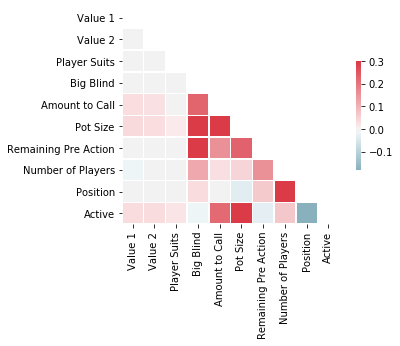

In [13]:
viz = hero_view[features_pre]

# Compute the correlation matrix
corr = viz.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

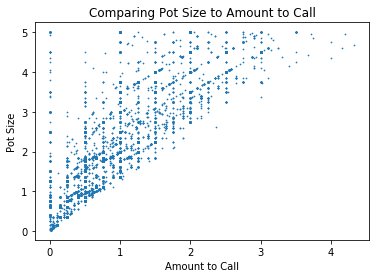

In [14]:
viz = hero_view[hero_view['Pot Size']<=5]

plt.scatter(viz['Amount to Call'], viz['Pot Size'], s=0.5)
plt.title('Comparing Pot Size to Amount to Call')
plt.xlabel('Amount to Call')
plt.ylabel('Pot Size')
plt.show()

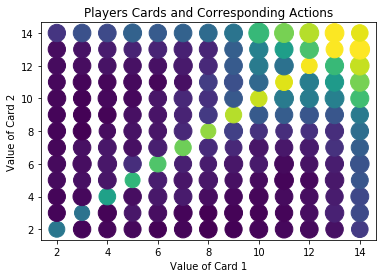

In [15]:
pivot1 = hero_view.pivot_table(index=['Value 1', 'Value 2'], columns='actions', aggfunc='size', fill_value=0)
pivot1 = pivot1.reset_index()
pivot1['Count'] = (pivot1[' calls ']+pivot1[' checks']+pivot1[' raises ']+pivot1[' folds'])
pivot1['Agg'] = (pivot1[' raises ']+0.75*pivot1[' calls ']+0.5*pivot1[' checks'])/(pivot1['Count'])
plt.scatter(pivot1['Value 1'], pivot1['Value 2'], s=pivot1['Count'], c=pivot1['Agg'])
plt.title('Players Cards and Corresponding Actions')
plt.xlabel('Value of Card 1')
plt.ylabel('Value of Card 2')
plt.show()

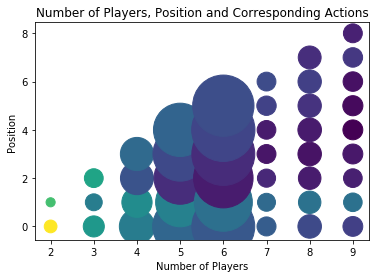

In [16]:
pivot1 = hero_view.pivot_table(index=['Number of Players', 'Position'], columns='actions', aggfunc='size', fill_value=0)
pivot1 = pivot1.reset_index()
pivot1['Count'] = (pivot1[' calls ']+pivot1[' checks']+pivot1[' raises ']+pivot1[' folds'])
pivot1['Agg'] = (pivot1[' raises ']+0.75*pivot1[' calls ']+0.5*pivot1[' checks'])/(pivot1['Count'])
plt.scatter(pivot1['Number of Players'], pivot1['Position'], s=pivot1['Count'], c=pivot1['Agg'])
plt.title('Number of Players, Position and Corresponding Actions')
plt.xlabel('Number of Players')
plt.ylabel('Position')
plt.show()